# Exploring Portfolio Risk Factors and Exposure with Python
## by Alexander Jeanis

## Introduction

Today we will be exploring various measures of portfolio risk such as:
 - Historical Value At Risk
 - Parametric (Variance-Covariance) Value At Risk
 - Expected Shortfall (also known as Conditional Value At Risk)
 - Maximum Drawdown
 - Portfolio Factor Exposures

To do this, we will create a sample portfolio of stocks and then calculate the aforementioned risk metrics.

## Libraries and Packages

In [16]:
import numpy as np
import pandas as pd
from scipy.stats import norm

from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS

import yfinance as yf

import matplotlib.pyplot as plt

## Importing Stock Data and Creating Our Sample Portfolio


For this project, I will be constructing an equally weighted portfolio of the 10 largest stocks at the time of writing (April 2021) excluding Tesla.

**Note:**
 - We will be using adjusted close data which accounts for dividends, stock splits (or buybacks), and rights offerings.
 - This portfolio will be equally weighted at inception but will not be rebalanced (I will come back at a later date to implement rebalancing) 
***

In [17]:
Tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'FB', 'BRK-B', 'JPM', 'V', 'JNJ', 'WMT']
data = yf.download(Tickers, start="2016-01-01", end="2021-04-01")
df = data["Adj Close"].dropna(how="all")

returns = df.pct_change()
returns = returns.iloc[1:]

stock_weights = np.full((1, 10), .1, dtype=float)
portfolio_size = 100000

[*********************100%***********************]  10 of 10 completed


## Value at Risk

_Generally speaking, what is Value at Risk?_

From Risk.net:

<blockquote>
[Value at Risk] is defined as the maximum dollar amount expected to be lost over a given time horizon, at a pre-defined confidence level. For example, if the 95% one-month (day) VAR is 1 million, there is 95% confidence that over the next month (day) the portfolio will not lose more than 1 million.
</blockquote>

**Value at Risk is usually calculated with three methods: Historical, Parametric, and Monte Carlo.**

Today we will only be going over the _historical_ and _parametric_ methods (I will return and add a Monte Carlo method at a later date)


## Historical Value at Risk

Lets begin our exploration in Value at Risk with one of the most straightforward calculation methods: *Historical Value At Risk*

Historical Value At Risk uses actual past returns to determine the extent of worst case losses for a given portfolio / stock. Essentially, daily returns are ranked from worst to best and then a value is selected based on our chosen significance level. 

In order to calcuate Historical VaR we will need to:

 - Calculate our portfolio's daily returns.
 - Order returns and then take the (1-confidence interval) percentile of returns. 
    - Ex. For 95% VaR, we will be taking the 5th percentile of returns over the period

Thats it!

We will begin by calculating our portfolio's daily returns with the following formula:
<blockquote>
$ \sum_{i=1}^{n} (w_{i} * r_{i})  = \ $Portfolio Return
</blockquote>
(Just sum the weighted return of each stock to obtain the portfolio return.)
***

In [18]:
daily_stock_returns = returns * stock_weights
#could also just multiply the whole df by 10% since the weights are equal
daily_portfolio_returns = daily_stock_returns.sum(axis=1)
daily_portfolio_returns

Date
2016-01-05    0.002148
2016-01-06   -0.005778
2016-01-07   -0.025081
2016-01-08   -0.009275
2016-01-11    0.005493
                ...   
2021-03-25   -0.001075
2021-03-26    0.012993
2021-03-29    0.005675
2021-03-30   -0.005905
2021-03-31    0.004817
Length: 1319, dtype: float64

***

**Now that we have a list of our portfolio's daily returns, calculating daily VaR is easy:**

***

In [108]:
VAR_90 = daily_portfolio_returns.quantile(.1)
VAR_95 = daily_portfolio_returns.quantile(.05)
VAR_99 = daily_portfolio_returns.quantile(.01)

print("The 90% One Day Historical Value at Risk is {}%".format(round((VAR_90 * 100),2)))
print("The 95% One Day Historical Value at Risk is {}%".format(round((VAR_95 * 100),2)))
print("The 99% One Day Historical Value at Risk is {}%".format(round((VAR_99 * 100),2)))

The 90% One Day Historical Value at Risk is -1.09%
The 95% One Day Historical Value at Risk is -1.83%
The 99% One Day Historical Value at Risk is -3.66%


***

With 1-day Value at Risk computed, we can now calculate multi-day estimates of VaR.

**For this task, we will simply multiply the 1-day q% VaR by the square root of the day number.**

**Note:** [We are able to do this because volatility scales as square root of time](https://www.macroption.com/why-is-volatility-proportional-to-square-root-of-time/#:~:text=For%20price%20making%20a%20random,the%20square%20root%20of%20time.)
***

In [75]:
H_VaR_90_list = []
H_VaR_95_list = []
H_VaR_99_list = []

for i in range(1, 31):    
    H_VaR_90_list.append(abs(np.round(VAR_90 * np.sqrt(i),4)))
    H_VaR_95_list.append(abs(np.round(VAR_95 * np.sqrt(i),4)))
    H_VaR_99_list.append(abs(np.round(VAR_99 * np.sqrt(i),4)))


***

__Next, lets plot the historical VaR for each q% and observe the graphs.__

***

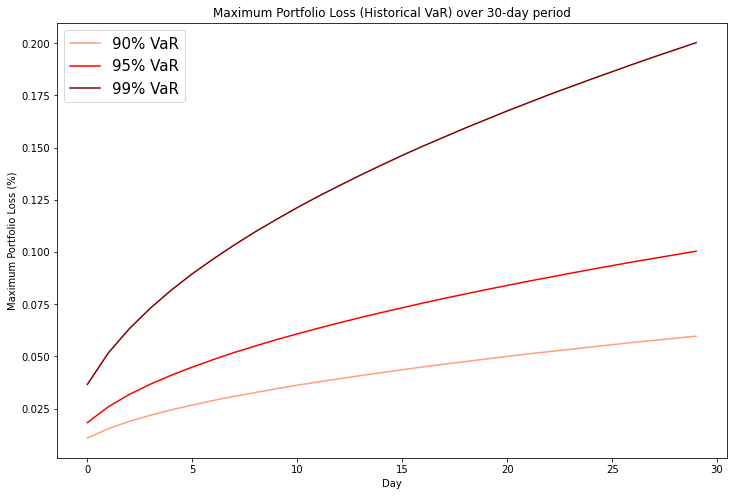

In [106]:
plt.figure(figsize=(12,8))
plt.xlabel("Day")
plt.ylabel("Maximum Portfolio Loss (%)")
plt.title("Maximum Portfolio Loss (Historical VaR) over 30-day period")
plt.plot(H_VaR_90_list, "lightsalmon")
plt.plot(H_VaR_95_list, "red")
plt.plot(H_VaR_99_list, "maroon")
plt.legend(['90% VaR', '95% VaR', '99% VaR'], prop={'size': 15});


**Thus, we can say with 99% certainty that our portfolio will not lose more than ~20% in one month when assessed using historical VaR.**

## Variance-Covariance (Parametric) Value At Risk

The Variance-Covariance approach to value at risk uses portfolio mean and standard deviation to predict possible loss values.
This method is parametric, meaning that it assumes stock returns will follow a normal distribution.

To calculate Parametric VaR, we will use the following items:
 - [SciPy norm.ppf](https://www.kite.com/python/docs/scipy.stats.norm.ppf)
 - Daily Portfolio Return Mean
 - Daily Portfolio Return Standard Deviation
***

In [109]:
# Calculating average daily portfolio return
mean_portfolio_returns = daily_portfolio_returns.mean()

# Calculating daily portfolio standard deviation
portfolio_standard_deviation = np.std(daily_portfolio_returns) * np.sqrt(1)

#next we plug in our portfolio mean / sd into ppf with the desired significance level
ppf_90 = norm.ppf(.1, mean_portfolio_returns, portfolio_standard_deviation)
ppf_95 = norm.ppf(.05, mean_portfolio_returns, portfolio_standard_deviation)
ppf_99 = norm.ppf(.01, mean_portfolio_returns, portfolio_standard_deviation)

print("The 90% One Day Parametric Value at Risk is {}%".format(round((ppf_90 * 100),2)))
print("The 95% One Day Parametric Value at Risk is {}%".format(round((ppf_95 * 100),2)))
print("The 99% One Day Parametric Value at Risk is {}%".format(round((ppf_99 * 100),2)))

The 90% One Day Parametric Value at Risk is -1.52%
The 95% One Day Parametric Value at Risk is -1.98%
The 99% One Day Parametric Value at Risk is -2.84%


***
Now that we have 1-day parametric VaR estimates, we can compute multi-day estimates as shown previously.
***

In [105]:
P_VaR_90_list = []
P_VaR_95_list = []
P_VaR_99_list = []


for i in range(1, 31):    
    P_VaR_90_list.append(abs(np.round(ppf_90 * np.sqrt(i),4)))
    P_VaR_95_list.append(abs(np.round(ppf_95 * np.sqrt(i),4)))
    P_VaR_99_list.append(abs(np.round(ppf_99 * np.sqrt(i),4)))


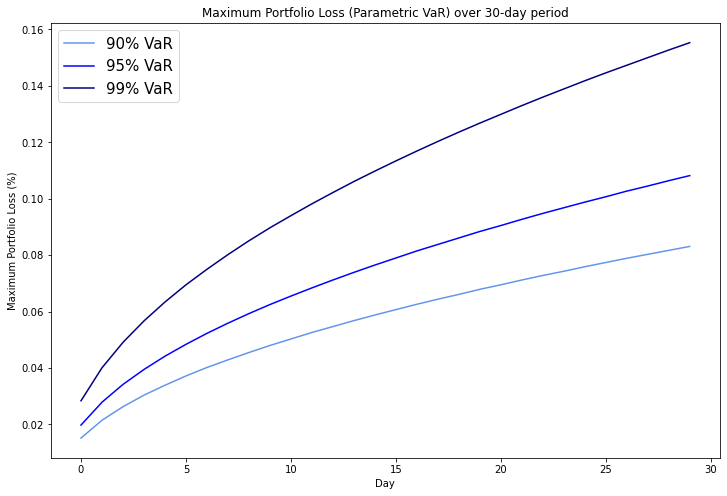

In [99]:
plt.figure(figsize=(12,8))
plt.xlabel("Day")
plt.ylabel("Maximum Portfolio Loss (%)")
plt.title("Maximum Portfolio Loss (Parametric VaR) over 30-day period")
plt.plot(P_VaR_90_list, "cornflowerblue")
plt.plot(P_VaR_95_list, "blue")
plt.plot(P_VaR_99_list, "navy")
plt.legend(['90% VaR', '95% VaR', '99% VaR'], prop={'size': 15})


**Thus, we can say with 99% certainty that our portfolio will not lose more than ~16% in one month when assessed using parametric VaR.**

## Comparison of Parametric / Historical VaR

Lets review some of the different considerations that affect our VaR calculation methods before visualizing them.


**Parametric VaR:**
 - Parametric VaR assumes the normality of returns (in real life returns have fatter tails and are harder to model)
     - Usually deemed worse than historical VaR for this reason.
 - works well with limited data

**Historical VaR:**
 - Historical VaR removes the assumption of normally distributed returns
 - Choosing the historical time period for our VaR calculation is critical 
     - Historical returns (and VaR) will be heavily dependent on economic conditions and extreme (negative) events
 - Generally requires clean portfolio data and will struggle when portfolio constituents are dynamically changing over time

***

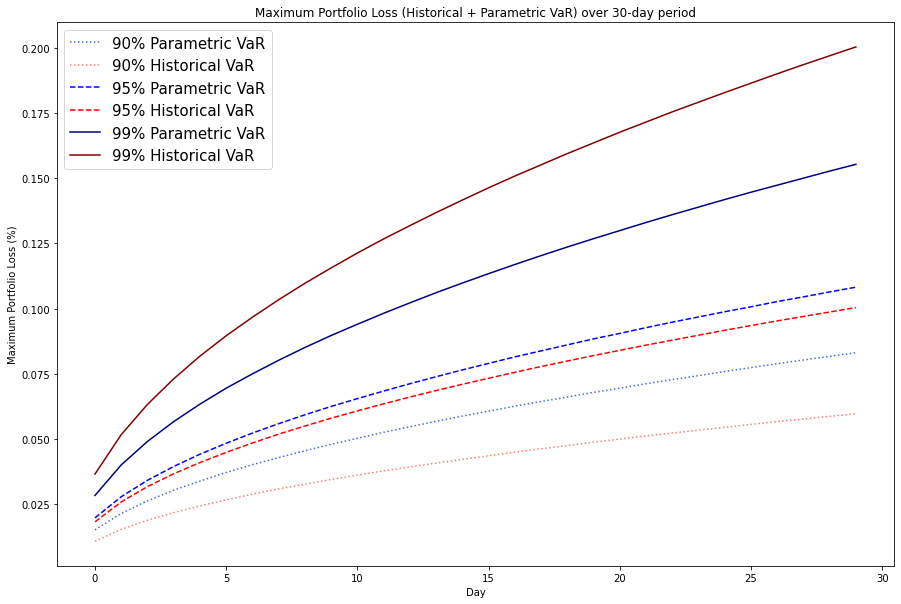

In [111]:
plt.figure(figsize=(15,10))
plt.xlabel("Day")
plt.ylabel("Maximum Portfolio Loss (%)")
plt.title("Maximum Portfolio Loss (Historical + Parametric VaR) over 30-day period")

plt.plot(P_VaR_90_list, "royalblue", linestyle=':')
plt.plot(H_VaR_90_list, "salmon", linestyle=':')

plt.plot(P_VaR_95_list, "blue",linestyle='--')
plt.plot(H_VaR_95_list, "red",linestyle='--')

plt.plot(P_VaR_99_list, "navy")
plt.plot(H_VaR_99_list, "maroon")

plt.legend(['90% Parametric VaR','90% Historical VaR', '95% Parametric VaR',
            '95% Historical VaR', '99% Parametric VaR','99% Historical VaR' ], prop={'size': 15});

***
In the case of our particular portfolio, we can see that 99% historical VaR exceeds 99% parametric VaR, while both 90% and 95% parametric VaR exceed their respective historical VaRs.

_Why is this?_

I would hypothesize that because our historical sample period (2016-2021) includes COVID-19 in the middle of an unprecedented bull market, lower q% Values at Risk should be smaller (less losing days as the market only goes up), while higher q% values at Risk should be larger (due to the market crash in Feb-Mar 2020 contained within the period)
***

## Historical CVaR / Expected Shortfall
*Conditional Value At Risk* or _Expected Shortfall_ is another form of VaR which seeks to quantify extreme tail risk in slightly different way to traditional VaR.

From Risk.net:

<blockquote>
Expected shortfall is a risk measure sensitive to the shape of the tail of the distribution of returns on a portfolio, unlike the more commonly used value-at-risk (VAR). Expected shortfall is calculated by averaging all of the returns in the distribution that are worse than the VAR of the portfolio at a given level of confidence. For instance, for a 95% confidence level, the expected shortfall is calculated by taking the average of returns in the worst 5% of cases.
</blockquote>

The following image should illustrate the need for this metric quite well ([also from risk.net](https://www.risk.net/risk-magazine/technical-paper/1506669/var-versus-expected-shortfall))
***

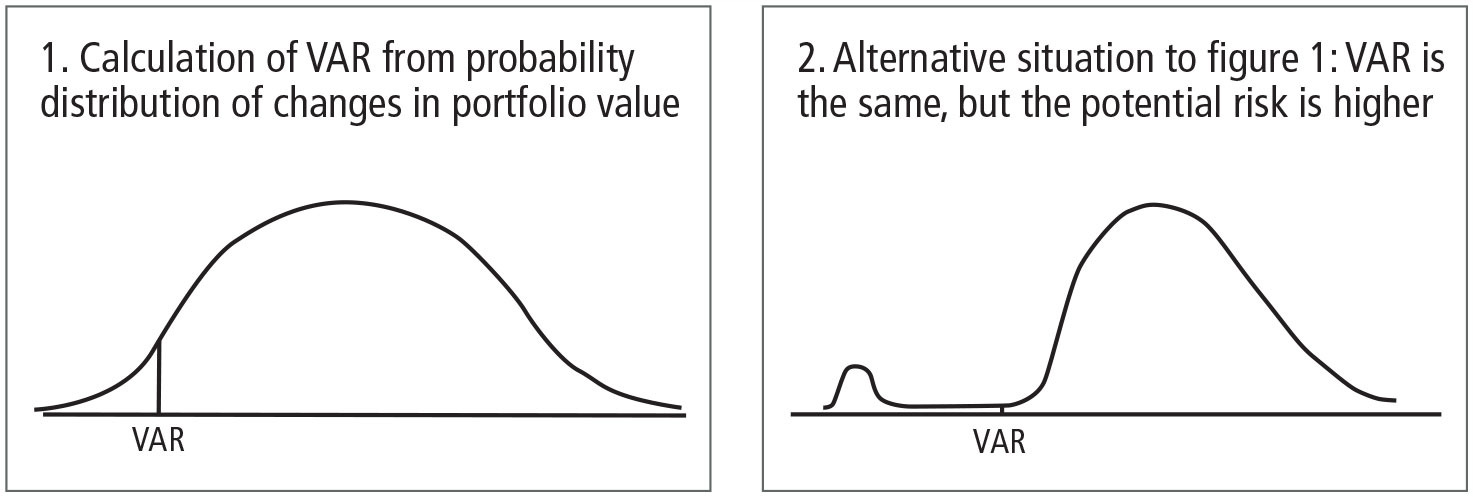

In [14]:
{
    "tags": [
        "hide-input",
    ]
}
from IPython.display import Image
Image(filename='hull-fig-1-and-2.jpeg') 

In [20]:
CVAR_90 = []
CVAR_95 = []
CVAR_99 = []

sorted_portfolio_returns = daily_portfolio_returns.sort_values(ascending=True)
#appennding all values worse than q% cutoff to their respective lists
for i in sorted_portfolio_returns:
    if i < VAR_90:
        CVAR_90.append(i)
    if i < VAR_95:
        CVAR_95.append(i)
    if i < VAR_99:
        CVAR_99.append(i)

#CVAR is average of all values pasted q%
CVAR_90 = sum(CVAR_90) / len(CVAR_90)
CVAR_95 = sum(CVAR_95) / len(CVAR_95)
CVAR_99 = sum(CVAR_99) / len(CVAR_99)

print("The 90% Conditional Value at Risk is {}%".format(round((CVAR_90 * 100),2)))
print("The 95% Conditional Value at Risk is {}%".format(round((CVAR_95 * 100),2)))
print("The 99% Conditional Value at Risk is {}%".format(round((CVAR_99 * 100),2)))

The 90% Conditional Value at Risk is -2.27%
The 95% Conditional Value at Risk is -3.15%
The 99% Conditional Value at Risk is -5.09%


## Maximum Drawdown

Maximum Drawdown is the [maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained.](https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp)
<br>
<br>
**Its formula is denoted:**
<blockquote>
$ MDD = \frac{P-L}{P} \\ $
</blockquote>

__where *P = Peak Value Before Largest Drop*
and *L = Lowest Value Before New High*__

Lets begin by construction our daily portfolio value in one dataframe so that we can proceed wih calculations.

Our portfolio will be constructed by investing $10000 in each of the stocks mentioned earlier at the start of 2016. 
***

In [112]:
shares = []
#calculating how many shares of each stock to buy (10000/share_price)
for i in df:
    shares.append((portfolio_size / len(Tickers)) / df[i][0])

portfolio_tracker = df * shares
portfolio_tracker = portfolio_tracker.sum(axis=1)


***
Lets visualize the portfolios performance and look for likely max drawdown periods (Spoiler: its going to COVID-19)
***

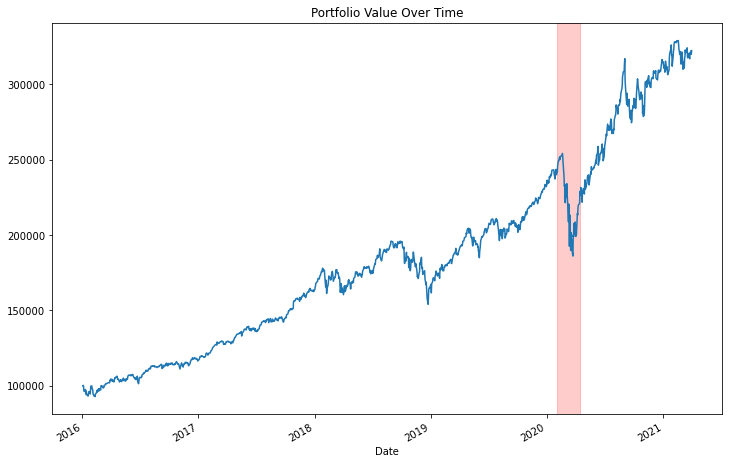

In [117]:
portfolio_tracker.plot(figsize=(12,8))
plt.axvspan('2020-02-01', '2020-04-15', color='red', alpha=0.2)
plt.title("Portfolio Value Over Time");

***
Now, we will calculate maximum drawdown using [Pandas' Rolling function](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)

For this project, I will examine the daily runnning drawdown as well as the year max drawdown over our time period (see calculations below) 
***

In [120]:
rolling_max = portfolio_tracker.rolling(252, min_periods=1).max()

daily_drawdown = (portfolio_tracker/rolling_max) - 1

max_daily_drawdown = daily_drawdown.rolling(252, min_periods=1).min()

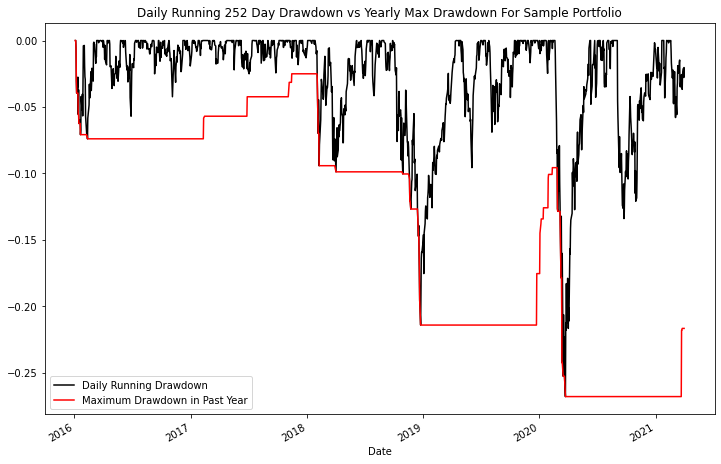

In [125]:
daily_drawdown.plot(figsize=(12,8), color = 'black')
max_daily_drawdown.plot(color = 'red')

plt.legend(['Daily Running Drawdown', 'Maximum Drawdown in Past Year'], prop={'size': 10})

plt.title("Daily Running 252 Day Drawdown vs Yearly Max Drawdown For Sample Portfolio");

In [124]:
maximum_drawdown = min(max_daily_drawdown.dropna())
start_date = portfolio_tracker.index[0].strftime('%Y-%m-%d')
end_date = portfolio_tracker.index[-1].strftime('%Y-%m-%d')
print("The maximum drawdown between {} and {} was {}%".format(start_date, end_date, round(maximum_drawdown * 100,2)  ))

The maximum drawdown between 2016-01-04 and 2021-03-31 was -26.8%


**Thus, the maximum drawdown for our portfolio over this period was ~26.8%**

## Beta Factors

On top of looking at worst case scenario risk factors like VAR, we should take a deep dive into the factors that drive our  portfolios' returns. We will be using beta to examine the relationship of our portfolio to various sectors / factors. Traditionally, beta is used in the context of a stock's risk-relationship to the general *market* and is defined as:
<blockquote>
$ Beta = \frac{Covariance(Asset1, Benchmark)}{Variance(Benchmark)} \\  $ 
</blockquote>

In this section, we will be computing the beta of our portfolio to various benchmarks, then examining the results to assess factor neutrality.

First, lets begin by defining a function to calculate beta:

In [93]:
def beta_calculation(y,x):
    
    x = x.pct_change().iloc[1:]
    x = x.to_frame()
    x = x.values
    
    y = y.pct_change().iloc[1:]
    y = y.to_frame()
    y = y.values
    
    
    x = add_constant(x)
    model = OLS(y,x).fit()
    x = x[:, 1]
    
    return model.params[1]

Next, lets import some ETFs which should represent the performance of their respective facets. 

In [7]:
Factor_Tickers = ['MTUM', 'QUAL', 'IQLT', 'VTV', 'QQQ', 'SIZE', 'SPY', 'XLK', 'IXN','VNQ']
Factor_Dictionary = {'SPY': 'Market', 'MTUM': 'Momentum', 'IQLT': 'International Quality', 'QQQ': 'Large Cap',
                     'QUAL': 'Quality', 'SIZE': 'Size (Small / Medium)', 'VTV': 'Value', 'XLK': 'US Technology',
                    'IXN':'Global Technology', 'VNQ': 'US Real Estate'}
factor_data = yf.download(Factor_Tickers, start="2016-01-01", end="2021-04-01")
factor_df = factor_data["Adj Close"].dropna(how="all")

factor_df.head()

[*********************100%***********************]  10 of 10 completed


,IQLT,IXN,MTUM,QQQ,QUAL,SIZE,SPY,VNQ,VTV,XLK
Date,,,,,,,,,,
2016-01-04,21.832926,91.230064,67.328712,104.816719,58.056442,57.771698,181.917801,63.383949,70.094666,39.188770
2016-01-05,22.524345,90.963463,67.647499,104.634834,58.211578,57.771698,182.225494,64.607063,70.320999,39.086788
2016-01-06,21.478350,89.544685,67.291229,103.629753,57.518047,57.460899,179.926880,64.430031,69.319992,38.604694
2016-01-07,21.123779,87.021355,65.791069,100.384743,56.149208,56.473656,175.610184,63.174740,67.701019,37.464352
2016-01-08,20.884438,86.297684,65.162895,99.561531,55.510433,55.797226,173.682556,62.329830,66.900253,37.167686


In [94]:
for i in (Factor_Tickers):

    factor_beta = (beta_calculation(portfolio_tracker, factor_df[i]))
    
    print("The exposure of the portfolio to {} is {}".format(Factor_Dictionary[factor_df[i].name], round(factor_beta,2)))

The exposure of the portfolio to Momentum is 0.89
The exposure of the portfolio to Quality is 1.0
The exposure of the portfolio to International Quality is 0.85
The exposure of the portfolio to Value is 0.89
The exposure of the portfolio to Large Cap is 0.9
The exposure of the portfolio to Size (Small / Medium) is 0.85
The exposure of the portfolio to Market is 1.03
The exposure of the portfolio to US Technology is 0.83
The exposure of the portfolio to Global Technology is 0.83
The exposure of the portfolio to US Real Estate is 0.57


**As we can see, the portfolio takes on risk roughly equivalent to the broader market.** In other words, our portfolio will pretty much move in step with changes in overall market / sector value. 

_This was not unexpected, as our portfolio is comprised of diverse array of stocks, spanning multiple sectors and with both high / low beta components._



## Final Thoughts and Areas of Improvement

### The following are measures that I will implement in near future:

### Marginal Contribution to Risk 
 - Calculating Marginal Contribution to Risk for each stock in the portfolio

### Risk parity
 - Constructing a Risk Parity Portfolio (with equities, bonds, and commodities)

### Monte Carlo VaR
 - Implementing a Monte Carlo style Value at Risk calculation

### Fama French Factors
 - Testing our portfolio's relationship to Fama French Factors4

### Bond / Derivative Risk Metrics
 - Implementing VaR models and Counterparty Risk